In [36]:
import uproot
import numpy as np
import vector
import matplotlib.pyplot as plt
import awkward as ak
import pandas as pd
import heputils
from hist import Hist
import hist
import matplotlib.pyplot as plt

## Reading in Data/MC and Producing CSVs for diMuon events

In [31]:
data = uproot.open('/data/jareddb2/CAMPFIRE/DataMuons.root:mini')
mc_zmumu = uproot.open('/data/jareddb2/CAMPFIRE/mc_147771.Zmumu.root:mini')
variables = ['lep_n','lep_pt','lep_eta','lep_phi','lep_E','lep_charge','lep_type','mcWeight']

data_arrays = data.arrays(variables)
mc_arrays = mc_zmumu.arrays(variables)

In [3]:
def dimuon_p4_gen(dataset,pt_weight,file,save_csv):
    two_lepton_mask = dataset['lep_n'] == 2 

    lep_p4 = vector.zip({'pt': dataset['lep_pt']/1000.0*pt_weight, 'eta': dataset['lep_eta'], 'phi': dataset['lep_phi'], 'E': dataset['lep_E']/1000.0})
    two_lep_p4 = lep_p4[two_lepton_mask]
    first_lep_p4 = two_lep_p4[:, 0]
    second_lep_p4 = two_lep_p4[:, 1]
    sum_p4 = first_lep_p4 + second_lep_p4

    two_muon_mask = ((dataset['lep_charge'][two_lepton_mask][:,0] != dataset['lep_charge'][two_lepton_mask][:,1]) & (dataset['lep_type'][two_lepton_mask][:,0] == 13) & (dataset['lep_type'][two_lepton_mask][:,1] == 13))
    dimuon_p4 = sum_p4[two_muon_mask]
    muon1_p4 = first_lep_p4[two_muon_mask]
    muon2_p4 = second_lep_p4[two_muon_mask]

    if(save_csv):
        dataset_df = pd.DataFrame(data=[dimuon_p4.mass,muon1_p4.pt,muon1_p4.eta,muon1_p4.phi,muon1_p4.E,muon2_p4.pt,muon2_p4.eta,muon2_p4.phi,muon2_p4.E],index=['dimuon_mass','muon1_pt','muon1_eta','muon1_phi','muon1_E','muon2_pt','muon2_eta','muon2_phi','muon2_E'])
        dataset_df = dataset_df.T
        dataset_df.to_csv('/data/jareddb2/CAMPFIRE/'+file)
    
    return [dimuon_p4,muon1_p4,muon2_p4]

In [4]:
data_dimuon_p4, data_muon1_p4, data_muon2_p4 = dimuon_p4_gen(data_arrays,1.0,'data_dimuon_p4.csv',True)
mc_dimuon_p4, mc_muon1_p4, mc_muon2_p4 = dimuon_p4_gen(mc_arrays,1.0,'mc_dimuon_p4.csv',True)

In [ ]:
mc_dimuon_p4 = pd.read_csv('/data/jareddb2/CAMPFIRE/mc_dimuon_p4.csv')
data_dimuon_p4 = pd.read_csv('/data/jareddb2/CAMPFIRE/data_dimuon_p4.csv')

In [ ]:
data_dimuon_p4_cut = data_dimuon_p4[(data_dimuon_p4['dimuon_mass'] >= 60.0) & (data_dimuon_p4['dimuon_mass'] <= 120.0)].reset_index(drop=True)
data_dimuon_p4_cut = data_dimuon_p4_cut.drop(data_dimuon_p4_cut.columns[0],axis=1)
data_dimuon_p4_cut.to_csv('/data/jareddb2/CAMPFIRE/data_dimuon_FINAL.csv')

mc_dimuon_p4_cut = mc_dimuon_p4_cut = mc_dimuon_p4[(mc_dimuon_p4['dimuon_mass'] >= 60.0) & (mc_dimuon_p4['dimuon_mass'] <= 120.0)].reset_index(drop=True)
mc_dimuon_p4_sample = mc_dimuon_p4_cut.sample(n=len(data_dimuon_p4_cut),replace=False).reset_index(drop=True)
mc_dimuon_p4_sample = mc_dimuon_p4_sample.drop(mc_dimuon_p4_sample.columns[0],axis=1)
mc_dimuon_p4_sample.to_csv('/data/jareddb2/CAMPFIRE/mc_dimuon_FINAL.csv')

## Post BDT Training/Testing and Post Re-weighting

In [26]:
data_df = pd.read_csv('/data/jareddb2/CAMPFIRE/data_dimuon_FINAL.csv')
mc_df = pd.read_csv('/data/jareddb2/CAMPFIRE/mc_dimuon_FINAL.csv')
mc_weight_df = pd.read_csv('/data/jareddb2/CAMPFIRE/mc_dimuon_weighted_cut.csv')

data_df['weight'] = np.ones(len(data_df['dimuon_mass']))
mc_df['weight'] = np.ones(len(mc_df['dimuon_mass']))

In [46]:
def make_hists(dataset_regions,variable,bins,min,max):
    total_hists = {}
    for i in range(len(dataset_regions)):
        single_hist = hist.Hist(hist.axis.Regular(bins,min,max,name=variable,label=variable,flow=False),storage=hist.storage.Weight())
        single_hist.fill(dataset_regions[i][variable], weight=dataset_regions[i]['weight'])
        total_hists[i] = single_hist

    return total_hists

def make_stack_ratio_plot(dataset_regions,variable,bins,min,max,xlabel,labels,colors,file):
    hists = make_hists(dataset_regions,variable,bins,min,max)
    simulation_hists = [hists[0]]
    data_hist = hists[1]
    labels = labels
    colormap = colors
    scale_factors = [1]

    heputils.plot.set_style("ATLAS")
    heputils.plot.set_experiment_info(status="Open Data")  # Internal, Preliminary, Public
    heputils.plot.set_experiment_info(center_of_mass_energy=13, center_of_mass_energy_units="TeV")  # Default values
    heputils.plot.set_experiment_info(luminosity=10, luminosity_units="fb")  # Default values

    fig = plt.figure()
    axs = heputils.plot.stack_ratio_plot(simulation_hists,data_hist=data_hist,ratio_numerator="data",rp_ylim=[0.8, 1.3],labels=labels,color=colormap,xlabel=xlabel,ylabel="Events",logy=True,scale_factors=scale_factors,rp_uncert_draw_type="line")
    ax = axs[0]
    ax.legend(loc="best")
    plt.savefig('/home/jareddb2/CAMPFIRE_plots/'+file+'.png',dpi=500,bbox_inches='tight')
    plt.show()

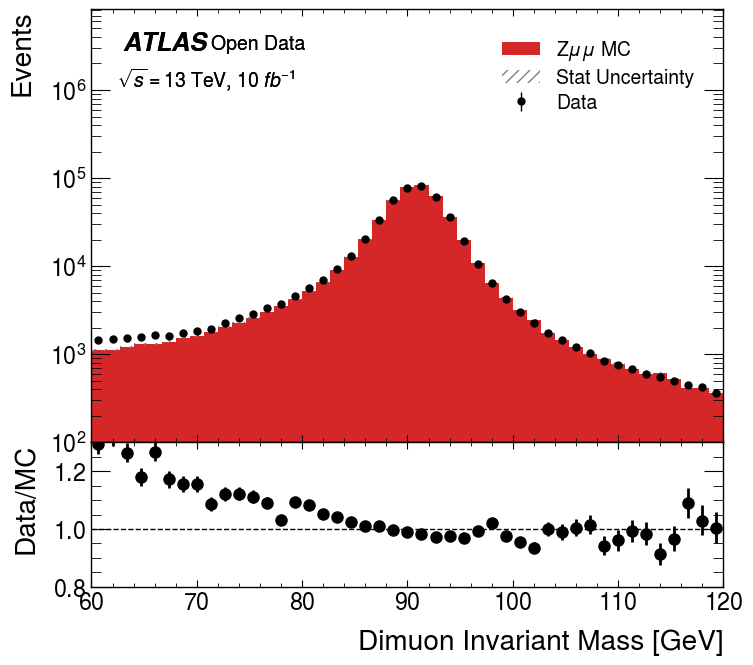

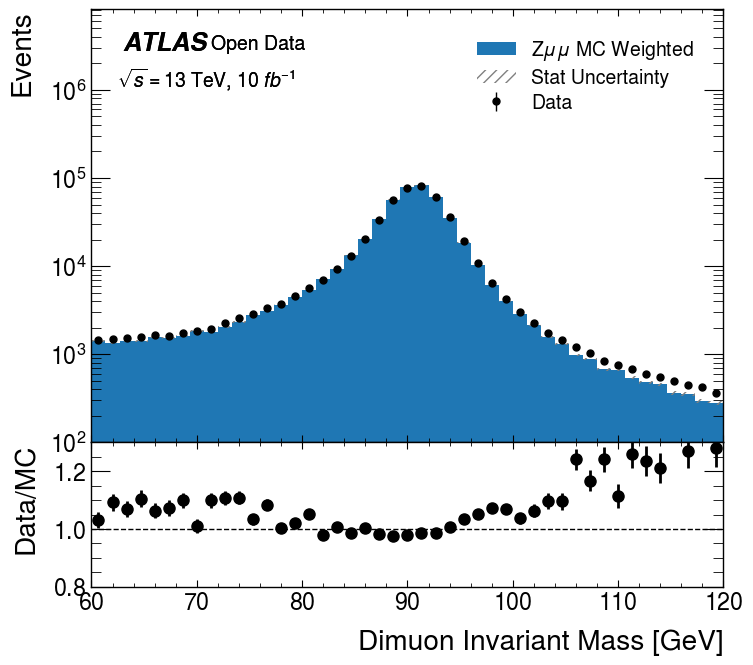

In [47]:
make_stack_ratio_plot([mc_df,data_df],'dimuon_mass',45,60,120,'Dimuon Invariant Mass [GeV]',['Z$\mu\mu$ MC'],['tab:red'],'data_mc_dimuon_mass_before')
make_stack_ratio_plot([mc_weight_df,data_df],'dimuon_mass',45,60,120,'Dimuon Invariant Mass [GeV]',['Z$\mu\mu$ MC Weighted'],['tab:blue'],'data_mc_dimuon_mass_after')